In [1]:
from IPython.core.display import HTML
from notebook_css import css
HTML(css)

In [113]:
import os
mnist_dir = '/notebooks/Freund\'s_Shrine/Data/MNIST/mnist_npy'

x_s_train = np.load(os.path.join(mnist_dir, 'mnist_train_images.npy'))
y_s_train = np.load(os.path.join(mnist_dir, 'mnist_train_labels.npy'))
x_s_test = np.load(os.path.join(mnist_dir, 'mnist_test_images.npy'))
y_s_test = np.load(os.path.join(mnist_dir, 'mnist_test_labels.npy'))

[7 2 1 0 4 1 4 9 5 9]


<IPython.core.display.Javascript object>


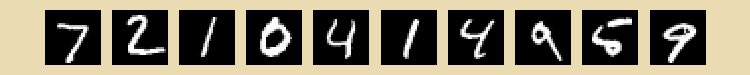

[7 3 4 6 1 8 1 0 9 8]


<IPython.core.display.Javascript object>


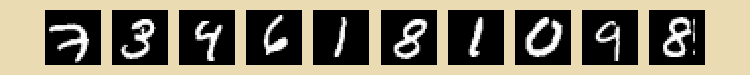

In [114]:
print(np.argmax(y_s_test[:10], 1))
image_plot([_.reshape(28,28) for _ in x_s_test[:10]])
print(np.argmax(y_s_train[:10], 1))
image_plot([_.reshape(28,28) for _ in x_s_train[:10]])

In [1]:
import numpy as np

import enn_v1_0
import feature_visualization as fv

from importlib import reload
reload(enn_v1_0)
from enn_v1_0 import ENN

[x_coords, y_coords] = fv.sampling('quadratic', 'matplotlib', 50)
xy1 = np.array([x_coords, y_coords+0.4])
xy2 = np.array([x_coords, y_coords-0.45])
""" `x` here means input feature vector x """
x_s_train = np.hstack([xy1, xy2]).T
y_s_train = np.array([[1, 0]]*50 + [[0, 1]]*50)

enn = ENN(max_degree=1, params_init='identity', learning_rate=1)    
trace_dict = enn.fit(x_s_train, y_s_train, 10, True)

training completed.


<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Module 6: Transformation Plotting</span></font>

<IPython.core.display.Javascript object>


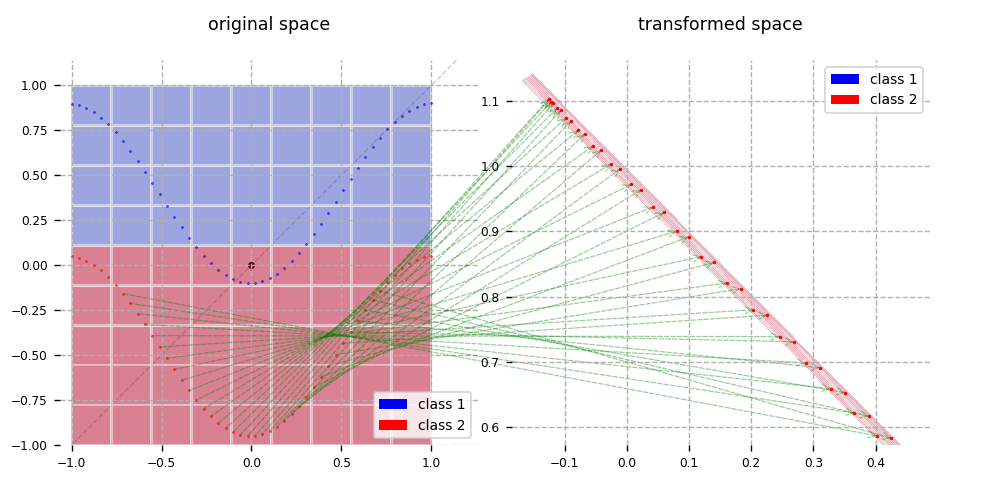

interactive(children=(IntSlider(value=0, description='step', max=10), Output()), _dom_classes=('widget-interac…

In [2]:
%matplotlib notebook
%matplotlib notebook
import nn_visualizer as NV

reload(NV)
from importlib import reload

enn_v = NV.nn_visualizer(x_s_train, y_s_train, enn, trace_dict)    
# # enn_v.dataset_plot()
enn_v.visualize('t', vt_type='w')
# enn_v.visualize('image_plot', image_type='logits', image_one_off=True)

In [4]:
print(trace_dict['W'])
print(trace_dict['b'])

[[[  1.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   1.00000000e+00]]

 [[  6.53061224e-01  -3.33249241e-03]
  [  1.98380985e-01   4.69777127e-01]]

 [[  4.25827860e-01  -3.74185029e-03]
  [  3.47814328e-01   1.13561952e-01]]

 [[  2.76932575e-01  -2.82210168e-03]
  [  4.52230725e-01  -1.33563237e-01]]

 [[  1.79346871e-01  -1.39790670e-03]
  [  5.25163673e-01  -3.05005568e-01]]

 [[  1.15374383e-01   1.03510079e-04]
  [  5.76084647e-01  -4.23945774e-01]]

 [[  7.34267383e-02   1.48039449e-03]
  [  6.11623253e-01  -5.06463699e-01]]

 [[  4.59139258e-02   2.65457468e-03]
  [  6.36417258e-01  -5.63713816e-01]]

 [[  2.78637489e-02   3.61217180e-03]
  [  6.53709307e-01  -6.03434108e-01]]

 [[  1.60182527e-02   4.36990893e-03]
  [  6.65765489e-01  -6.30992633e-01]]

 [[  8.24224126e-03   4.95659624e-03]
  [  6.74168713e-01  -6.50113456e-01]]]
[[ 0.          0.        ]
 [ 0.5         0.52157305]
 [ 0.50427968  0.51013452]
 [ 0.50750341  0.50244988]
 [ 0.50975599  0.49711863]
 [ 0.51

training completed.


<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Module 6: Transformation Plotting</span></font>

<IPython.core.display.Javascript object>


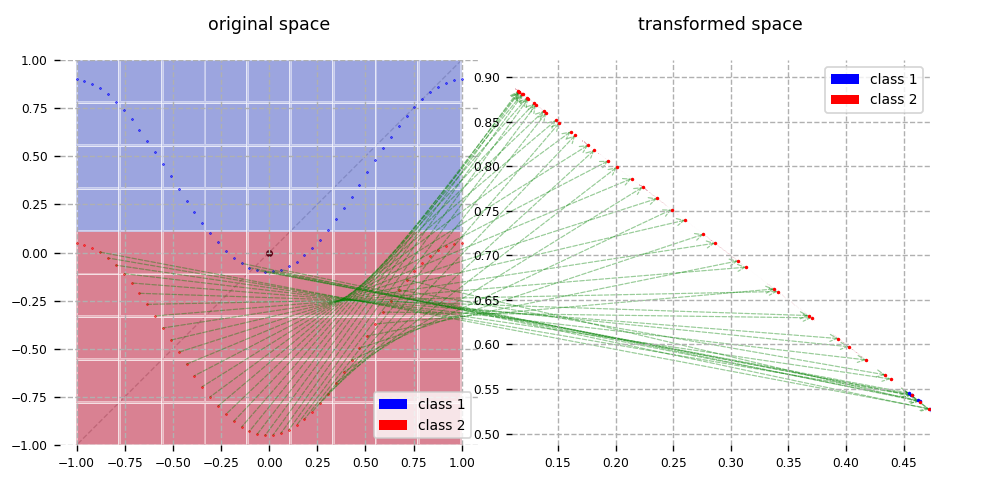

interactive(children=(IntSlider(value=0, description='step', max=10), Output()), _dom_classes=('widget-interac…

In [25]:
import simple_nn
reload(simple_nn)
from simple_nn import NN

nn = NN()
trace_dict = nn.fit(x_s_train, y_s_train,
                    params_trace_recording=True)

enn_v = NV.nn_visualizer(x_s_train, y_s_train, nn, trace_dict)    
enn_v.visualize('t', vt_type='w')


NameError: name 'nn' is not defined

In [26]:
print(trace_dict['W'])
print(trace_dict['b'])

[[[ 1.          0.        ]
  [ 0.          1.        ]]

 [[ 0.92323172  0.07676832]
  [ 0.27971214  0.72028786]]

 [[ 0.85375857  0.14624146]
  [ 0.52294713  0.47705287]]

 [[ 0.79390383  0.20609617]
  [ 0.73134428  0.26865572]]

 [[ 0.74419361  0.25580639]
  [ 0.90920627  0.09079377]]

 [[ 0.70368445  0.29631558]
  [ 1.06179655 -0.06179653]]

 [[ 0.6708138   0.3291862 ]
  [ 1.19408047 -0.19408043]]

 [[ 0.64402395  0.35597607]
  [ 1.3101778  -0.31017774]]

 [[ 0.62200767  0.37799233]
  [ 1.41330862 -0.41330868]]

 [[ 0.60374135  0.39625868]
  [ 1.50593662 -0.50593656]]

 [[ 0.58844221  0.41155779]
  [ 1.58994246 -0.58994246]]]
[[ 0.          0.        ]
 [-0.00937714  0.00937715]
 [-0.0090338   0.00903381]
 [-0.00432516  0.00432518]
 [ 0.00109324 -0.00109322]
 [ 0.00578692 -0.00578693]
 [ 0.00956047 -0.00956049]
 [ 0.01260417 -0.01260419]
 [ 0.01513691 -0.01513694]
 [ 0.01731966 -0.0173197 ]
 [ 0.01925691 -0.01925695]]


training completed.


<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Module 6: Transformation Plotting</span></font>

<IPython.core.display.Javascript object>


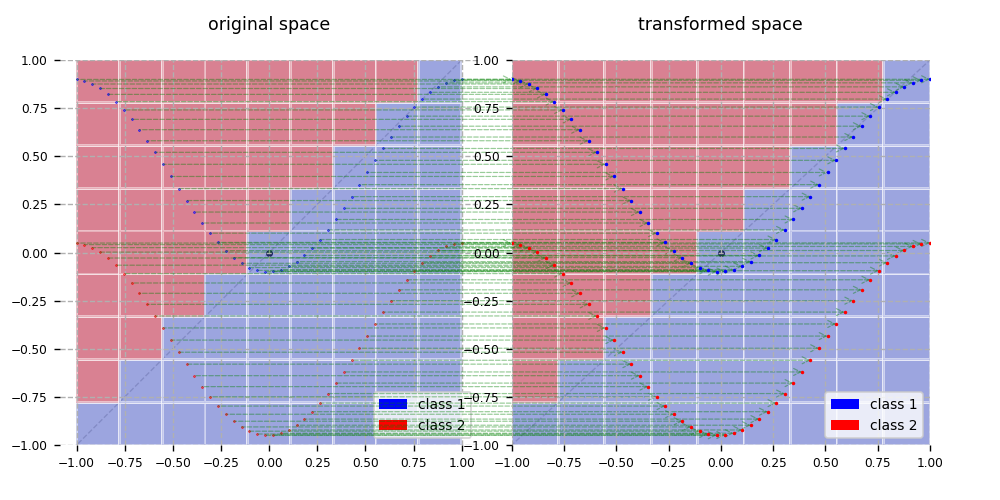

interactive(children=(IntSlider(value=0, description='step', max=10), Output()), _dom_classes=('widget-interac…

In [5]:
enn = ENN(max_degree=2, params_init='identity', learning_rate=1)    
trace_dict = enn.fit(x_s_train, y_s_train, 10, True)

enn_v = NV.nn_visualizer(x_s_train, y_s_train, enn, trace_dict)    
enn_v.visualize('t', vt_type='w')

In [76]:
enn_v.trace_dict['W'][40]

array([[-0.00666081,  0.00666082],
       [ 0.69344937, -0.69344897]])

In [9]:
# del ax_db
# enn_v.visualize('t')
[enn_v.params[0]]

[array([[-0.52258212,  0.12257024],
        [ 0.93590577,  0.59526269]])]

<IPython.core.display.Javascript object>


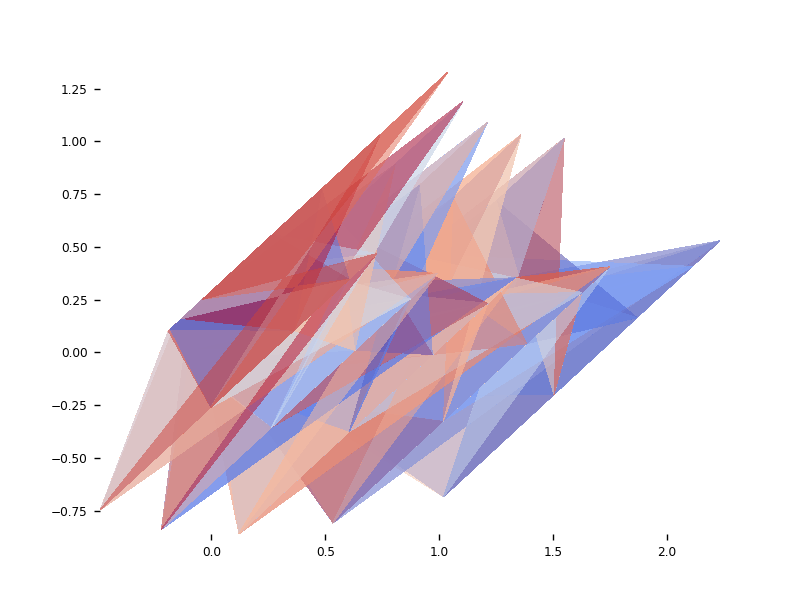

In [110]:
# print(*enn_v.f2.reshape(2, *enn_v.grid))
fig, ax = plt.subplots()
Z = np.random.random((10,10))
# Z = np.where(Z>0.5, 1, 0)
""" f2 is numpy-style """
ax.pcolormesh(*enn_v.f2.reshape(2, *enn_v.grid),Z , cmap='coolwarm', alpha=0.5)
plt.show()

In [36]:
"""
important notice: the matplotlib version is 2.1.0 and 2.2.3, and python version is 3.5.
"""
""" `step`: the index of training step. """
""" refreshing freq is too slow. how to optimize? """

In [3]:
""" reconstruct into class? """
# print(get_terms_for_display(enn.fp_transformation))
enn, trace_dict = training_process()

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 2: Training Process</span></font>

training completed.


<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 5: Decision Boundary Plotting</span></font>

<IPython.core.display.Javascript object>


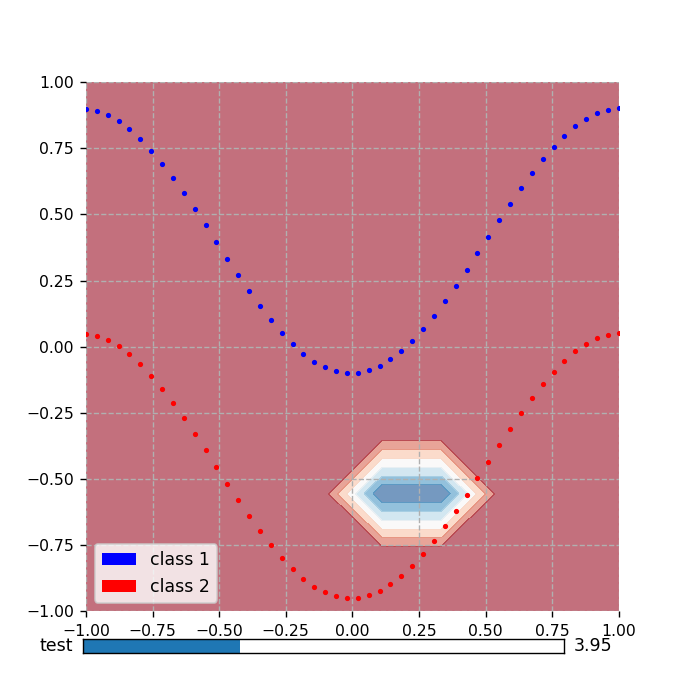

Training Accuracy: 0.5


0

In [68]:
import matplotlib.animation as animation

""" fig and ax must be created outside the `interact`, else empty figure \
will be rendered. """
# image_plot(x_s_train, 'raw feature')
# next(update(0))

# ani = animation.FuncAnimation(fig_t, update, frames=20, interval=50, blit=True)
# ani.save('test.mp4', dpi=300)

### Following Work
· visualize the gradients, weights, bias. (1)

· multiple graphs visualization in the case of max degree of freedom > 2. (2)

· visualize the space transformation. (3)

· increase the degree of freedom of ENN.

· try to analyze the 3-d data.

· XOR problem.

· add softmax, observe the independence among the gradients, and so on.

· spiral curve problem, conic problem, and so on.

· automatic derivatives calculation using sympy.

· optimize the calculation of value of the polynomial terms.

· linear cls (two line) & linear regression?

· would it converge faster when swapping the label blue and label red?

· remove the bias.

· 不规则的数据会怎样学习扭曲？batch呢？

· 如果是回归问题，转换又会变成什么样？

· w矩阵是如何从单位阵开始变成那样的？

· 样本不均衡

· 二次情况下，两个维度的分类器仍然保持对称吗？

· ENN的并行性——既可以按样本粒度，也可以按标签粒度！！

· two ENN terms **VS** three label??

### Design of Visualization Experiment: Step 1
1.feature
- histogram, space distribution, image-gram

2.weights, bias
- image-gram, histogram
- trace, gradients trace

3.transformed feature
- historam, space transformation, image-gram
- non-linear activation function learned dimension-wise in new space

4.softmax probability
- space transformation, classification boundary

5.loss, loss-sample-wise
- trace with step, trace with weights ($loss_{dim\_j}$ trace about $k\verb|-|th\ sample$), pie chart (proportions from each sample in $\Delta loss_{dim\_j}$, or proportions from each dim in $\Delta loss$ about $k\verb|-|th\ sample$)


### Design of Visualization Experiment: Step 2
| type | image | hist |
| - | - | - |
| `feature` | $1 \times 样本数$  | $1 \times [维度数 + 样本数(?)] \times 2$ |
| `W/b` | $1\ or\ steps \times 参数量$ | $steps \times (W的行+W的列+W[\text{TODO}])$ |
| `logits` | $steps \times 样本数$ | $steps \times [维度数 + 样本数(?)]$ |

<br>

| function signature | feature dimension | num of class |
| - | - | - |
| `dataset_plot` | <=3 | any |
| `vars_trace_plot` | any | any |
| `activation_func_plot` | <=3 | any |
| `decision_boundary_plot` | <=3 | any |
| `transformation_plot` | <=3 | any |
| `image_plot` | any | —— |
| `hist_plot` | any | any |

Visualization of plot when dimension > 3:
- contour plot
- 'pesudo high-dim plot surface'
- transformation plot
- section plot

<br>

### some minor tasks to do
- `w` hint of `vars_trace_plot`

### Step 4: Experiments of ENN (part 1)
1.Refactor all the classifiers.

2.Simple trail interfaces & speed performance? (现有的可视化轮子？)

3.PLA + LinReg；LinReg -> PLA -> LinReg -> PLA

4.将梯度的数量级进行放缩；梯度归一化

5.修改交叉熵的loss

6.梯度的独立性

7.one-hot进行放缩

8.小规模数据集？

9.cs229, error functions —— regression for classification —— data inner structure?

10.gradient descent in different data sets.

11.为什么一定要用softmax？线性回归既然有统计学、线性代数完整系统的解释和保证，那为什么拿到MNIST上就不好使了？非得加softmax？为什么？？为什么啊？



<br>

### Memo
1.Components
+ data (sparsity?)
+ weights initialization
+ label encoding
+ loss function & hypothesis of model
+ optimization algorithm
+ optimizer

In [ ]:
import matplotlib as mpl
print(mpl.get_backend())
print(mpl.is_interactive())

In [ ]:
# global_lc_s[0].get_segments()[0]
figaspect(3/10)

In [168]:
from enn_v1_0 import get_terms_collection as gtc
from enn_v1_0 import get_terms_expression as gte
import feature_visualization as fv

exp = lambda var_num, max_df: '+'.join([
    'w_%s' % i + term for i, term in enumerate(gte(gtc(2, 3)))
])

fv.md_display('$ % s$' % exp(2, 3))
for i in range(1, 4):
    fv.md_display('all terms of degree range 1~%s | $ %s $' % (i, ',\ '.join(
        gte(gtc(2, i))
    )))
print(gtc(2,1))
print(gtc(2,2))
print(gtc(2,2))

s = ''
for terms in itertools.combinations_with_replacement(np.vstack(gtc(2,2)), 2):
    s += '$ %s $ | ' % ',\ '.join(gte(terms))
fv.md_display(s)    

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$ w_0x_0+w_1x_1+w_2x^2_0+w_3x_0x_1+w_4x^2_1+w_5x^3_0+w_6x^2_0x_1+w_7x_0x^2_1+w_8x^3_1$</span></font>

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">all terms of degree range 1~1 | $ x_0,\ x_1 $</span></font>

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">all terms of degree range 1~2 | $ x_0,\ x_1,\ x^2_0,\ x_0x_1,\ x^2_1 $</span></font>

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">all terms of degree range 1~3 | $ x_0,\ x_1,\ x^2_0,\ x_0x_1,\ x^2_1,\ x^3_0,\ x^2_0x_1,\ x_0x^2_1,\ x^3_1 $</span></font>

[array([[1, 0],
       [0, 1]], dtype=int32)]
[array([[1, 0],
       [0, 1]], dtype=int32), array([[2, 0],
       [1, 1],
       [0, 2]], dtype=int32)]
[array([[1, 0],
       [0, 1]], dtype=int32), array([[2, 0],
       [1, 1],
       [0, 2]], dtype=int32)]


<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$ x_0,\ x_0 $ | $ x_0,\ x_1 $ | $ x_0,\ x^2_0 $ | $ x_0,\ x_0x_1 $ | $ x_0,\ x^2_1 $ | $ x_1,\ x_1 $ | $ x_1,\ x^2_0 $ | $ x_1,\ x_0x_1 $ | $ x_1,\ x^2_1 $ | $ x^2_0,\ x^2_0 $ | $ x^2_0,\ x_0x_1 $ | $ x^2_0,\ x^2_1 $ | $ x_0x_1,\ x_0x_1 $ | $ x_0x_1,\ x^2_1 $ | $ x^2_1,\ x^2_1 $ | </span></font>

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$ x_0, x_0, x_0, x_0 $</span></font>

<IPython.core.display.Javascript object>


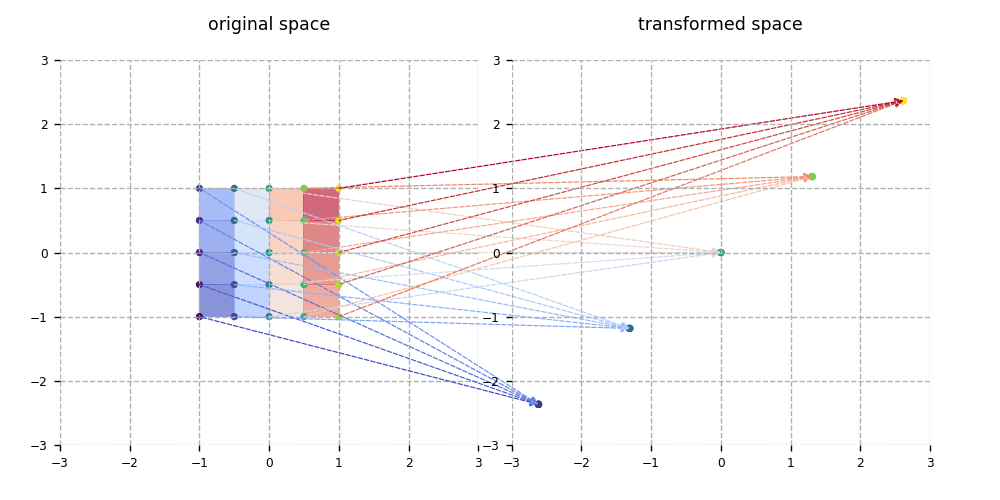

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$ x_0, x_0, x_0, x_1 $</span></font>

<IPython.core.display.Javascript object>


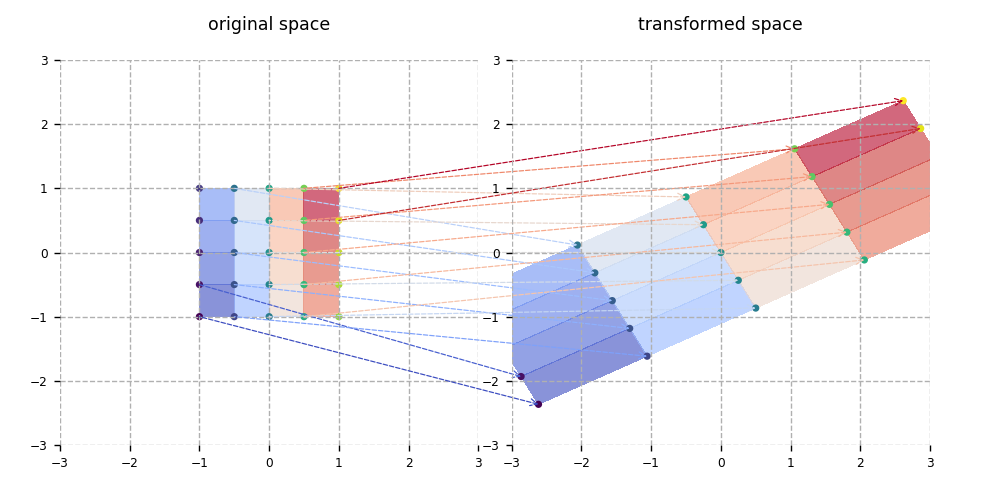

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$ x_0, x_0, x_0, x^2_0 $</span></font>

<IPython.core.display.Javascript object>


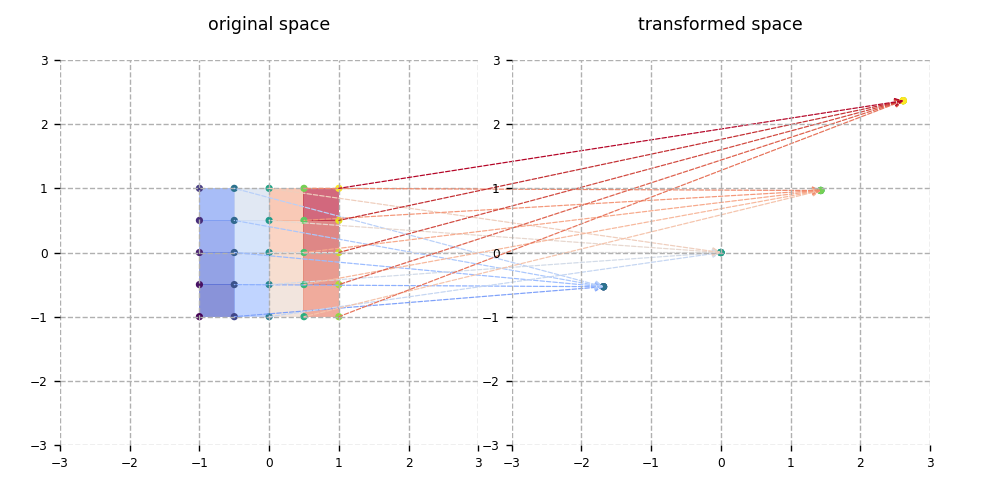

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$ x_0, x_0, x_0, x_0x_1 $</span></font>

<IPython.core.display.Javascript object>


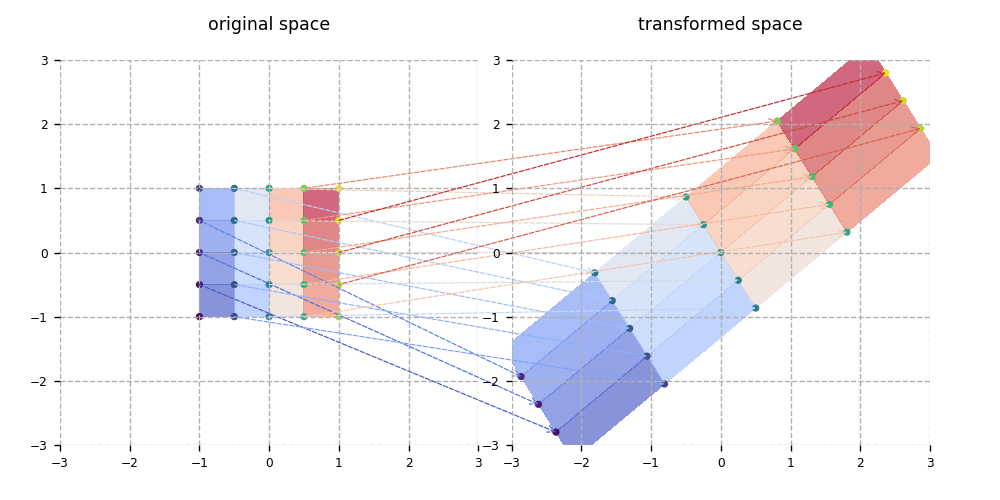

In [234]:
np.vstack([0,1])

array([[0],
       [1]])

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
import numpy as np
# X = sparse_random_matrix(10, 10, density=0.01, random_state=42)
X = np.array([[4,4], [-3,3]])
print(X)

svd = TruncatedSVD(algorithm='arpack', random_state=42)
svd.fit(X)  


print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

print(svd.singular_values_)  


In [102]:
X = np.array([[4,4], [-3,3]])
u, s, vh = np.linalg.svd(X, full_matrices=True)
print(u.shape, s.shape, vh.shape)
print(u)
print(s)
print(vh)

(2, 2) (2,) (2, 2)
[[-1.  0.]
 [ 0.  1.]]
[ 5.65685425  4.24264069]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


SyntaxError: can't assign to operator (<ipython-input-109-bf622b31d2c2>, line 16)

In [106]:
X = np.array([[4,4], [-3,3]])
u, s, vh = np.linalg.svd(X, full_matrices=False)
print(u.shape, s.shape, vh.shape)
print(u)
print(s)
print(vh)

(2, 2) (2,) (2, 2)
[[-1.  0.]
 [ 0.  1.]]
[ 5.65685425  4.24264069]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
